<a href="https://colab.research.google.com/github/DhiraSudabathula/Aspirenex/blob/main/Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install --upgrade pip'

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [75]:
import numpy as np
import pandas as pd, datetime
import io
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [1]:
from google.colab import files
uploaded = files.upload()

Saving store.csv to store.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [14]:
store = pd.read_csv(io.BytesIO(uploaded['store.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [7]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Explamatory Data Analysis

In [10]:
train.shape

(1017209, 9)

In [48]:
train['Year'] = train['Date'].apply(lambda x: int(str(x)[:4]))
train['Month'] = train['Date'].apply(lambda x: int(str(x)[5:7]))
train['Day'] = train['Date'].apply(lambda x: int(str(x)[8:10]))
train['DayOfWeek'] = train['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d').weekday())
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

In [49]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,SalesPerCustomer
0,1,4,2015-07-31,5263,555,1,1,0,1,2015,7,31,9.482883
1,2,4,2015-07-31,6064,625,1,1,0,1,2015,7,31,9.702400
2,3,4,2015-07-31,8314,821,1,1,0,1,2015,7,31,10.126675
3,4,4,2015-07-31,13995,1498,1,1,0,1,2015,7,31,9.342457
4,5,4,2015-07-31,4822,559,1,1,0,1,2015,7,31,8.626118


In [50]:
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,SalesPerCustomer
291,292,4,2015-07-31,0,0,0,1,0,1,2015,7,31,NaN
875,876,4,2015-07-31,0,0,0,1,0,1,2015,7,31,NaN
1406,292,3,2015-07-30,0,0,0,1,0,1,2015,7,30,NaN
1990,876,3,2015-07-30,0,0,0,1,0,1,2015,7,30,NaN
2521,292,2,2015-07-29,0,0,0,1,0,1,2015,7,29,NaN


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

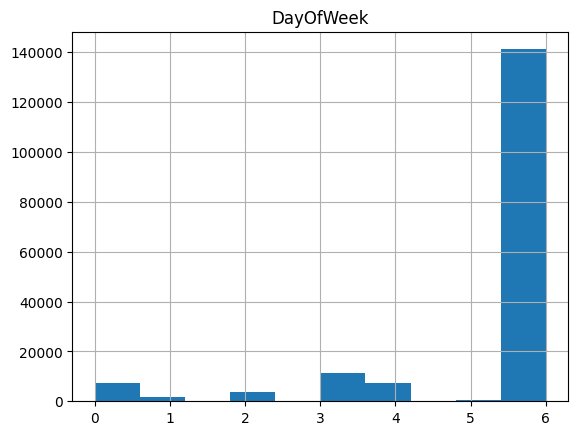

In [51]:
train_store_closed.hist('DayOfWeek')

<Axes: xlabel='SchoolHoliday'>

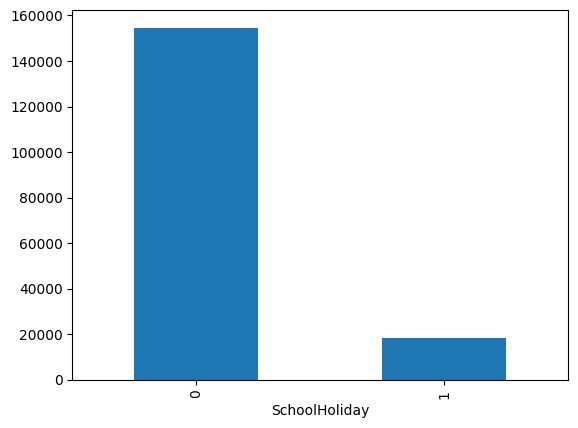

In [52]:
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar')

<Axes: xlabel='StateHoliday'>

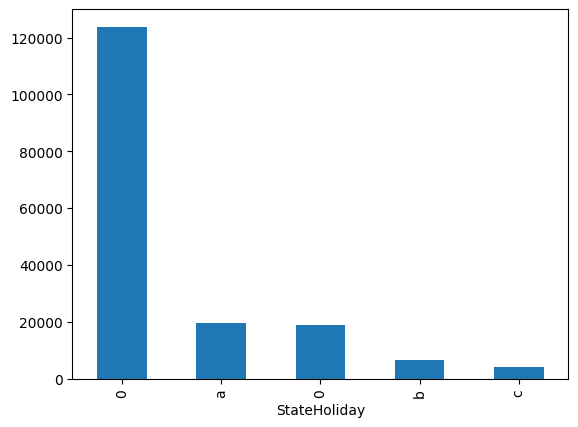

In [53]:
train_store_closed['StateHoliday'].value_counts().plot(kind = 'bar')

In [54]:
train.isnull().sum()

Store                    0
DayOfWeek                0
Date                     0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
SalesPerCustomer    172869
dtype: int64

In [55]:
train[(train.Open == 0)].shape[0]

172817

In [56]:
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [57]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [58]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [59]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [60]:
store.fillna(0, inplace=True)

In [61]:
store.isnull().sum().sum()

0

In [62]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [63]:
test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [64]:
test.fillna(1, inplace = True)

In [65]:
test.isnull().sum().sum()

0

In [66]:
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,3,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,2,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,1,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,0,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [67]:
train_store_joined.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)


,Customers,Sales,SalesPerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [69]:
train_store_joined[(train_store_joined.Open == 0) | (train_store_joined.Sales==0)].shape

(172871, 22)

In [106]:
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,3,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,2,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,1,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,0,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,0,2013-01-07,6905,471,1,1,0,1,2013,...,14.660297,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017204,1115,5,2013-01-05,4771,339,1,0,0,1,2013,...,14.073746,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,4,2013-01-04,4540,326,1,0,0,1,2013,...,13.926380,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,3,2013-01-03,4297,300,1,0,0,1,2013,...,14.323333,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


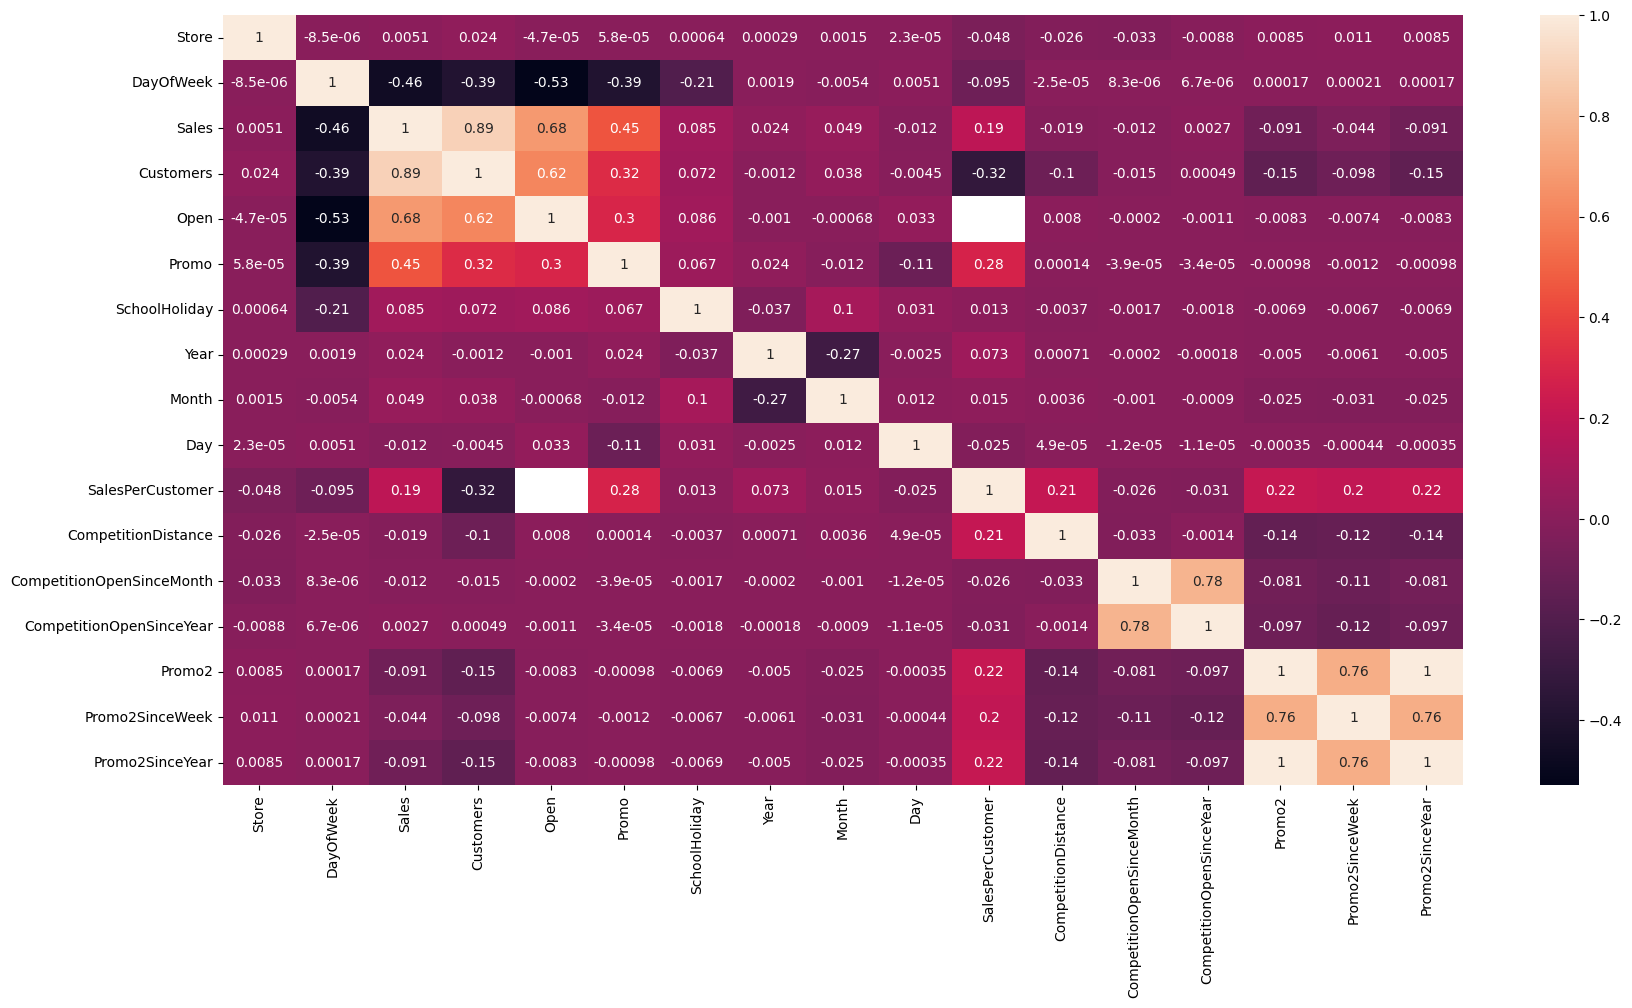

In [105]:
numeric_data = train_store_joined.select_dtypes(include=['number'])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()


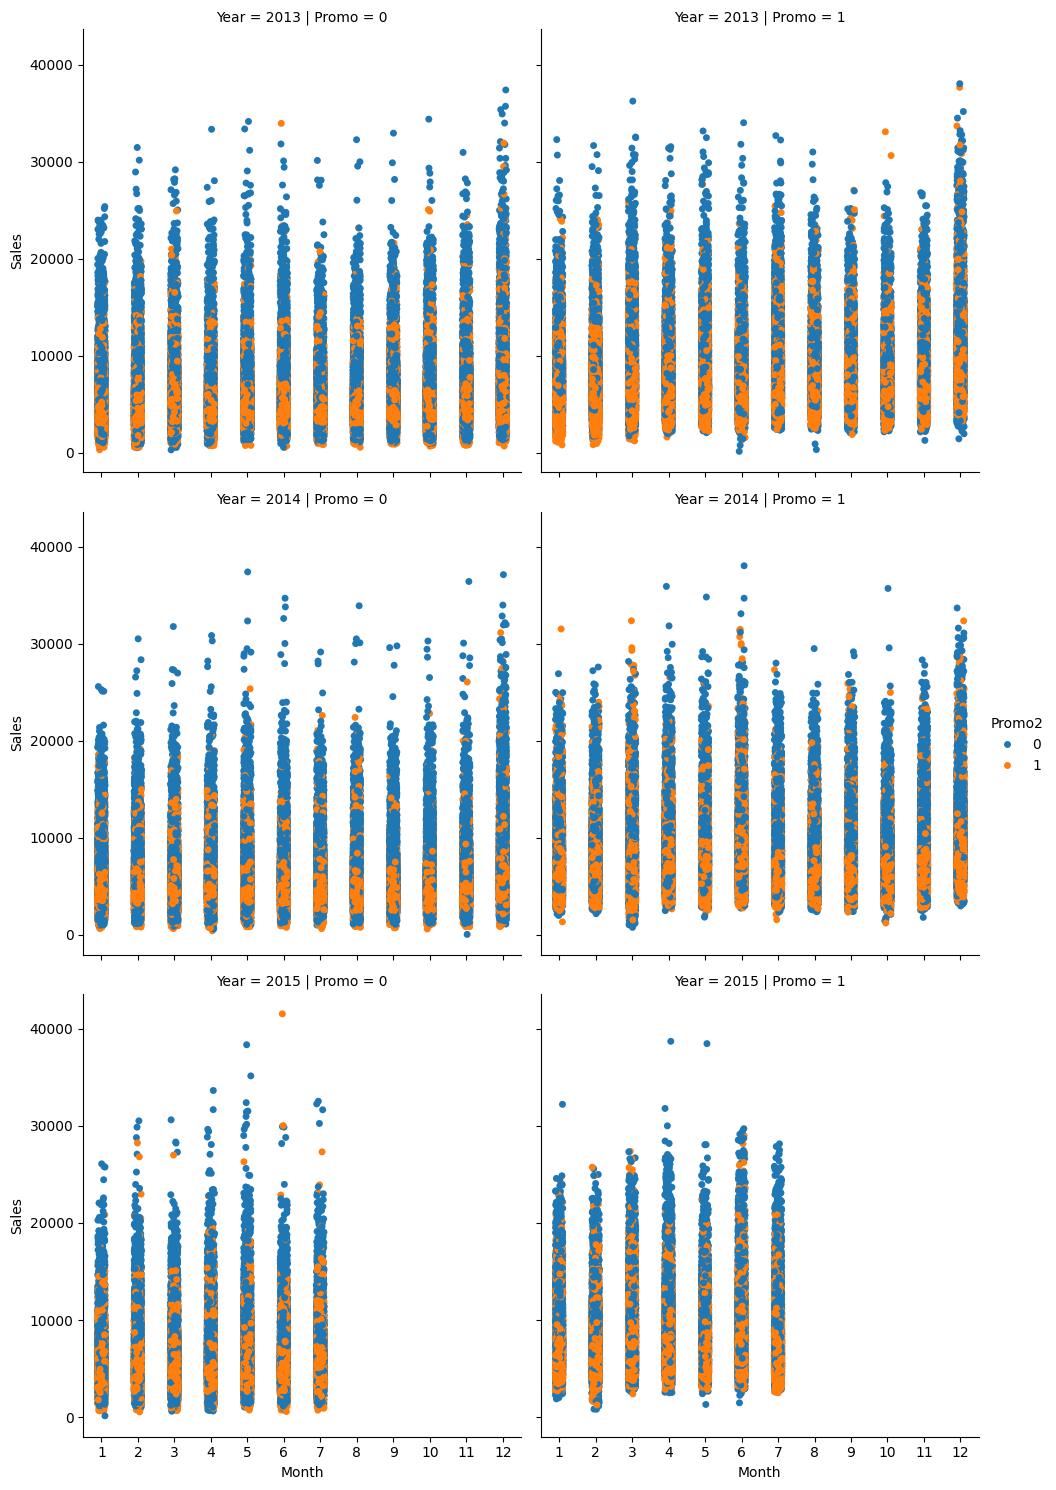

In [83]:
sns.catplot(data = train_store_joined_open, x='Month', y='Sales',
              col ='Promo', hue='Promo2', row='Year')

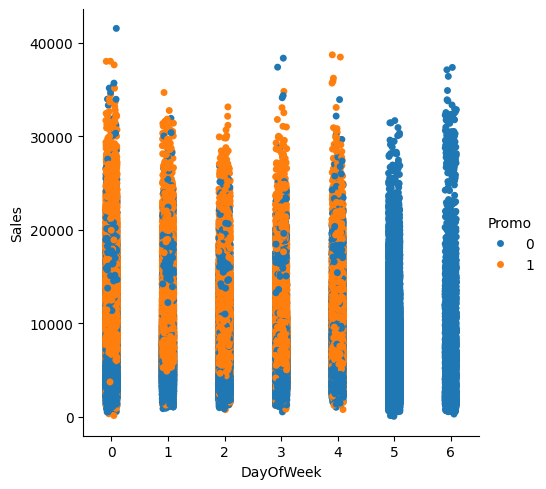

In [85]:
sns.catplot(data = train_store_joined_open, x='DayOfWeek', y='Sales',
              hue='Promo')

In [86]:
pd.plotting.register_matplotlib_converters()

In [94]:
train['Sales'] = train['Sales'] *1.00
train['Sales'].head()

0     5263.0
1     6064.0
2     8314.0
3    13995.0
4     4822.0
Name: Sales, dtype: float64

In [95]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

In [ ]:
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']
frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)

In [101]:
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')

    plt.legend(loc='best')
    plt.show()

    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')

    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

In [ ]:
test_stationarity(sales_a)

In [111]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

In [ ]:
plot_timeseries(sales_a, 'a')

In [ ]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')

In [ ]:
auto_corr(sales_a)


In [ ]:
auto_corr(sales_b)

In [ ]:
auto_corr(sales_c)

In [ ]:
auto_corr(sales_d)

In [ ]:
train_arima = train.resample('w').mean()
train_arima = train_arima[['Sales']]
train_arima.plot()

In [ ]:
train_arima.head()

In [ ]:
3
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[1])

In [ ]:
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

In [ ]:
pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

pred_ci = pred.conf_int()
ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [ ]:
train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')